In [87]:
run_optimization = False  # Here because the code in the notebook that optimizes is slow and painful to run often

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [89]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plot_dir = './plots/'
start_time = np.datetime64('2015-04-24T22:53:29')
end_time = np.timedelta64(1, 'D')
tc = test_case.TestCase(start_time=start_time, end_time=end_time)

# XXX

In [90]:
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [91]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [92]:
sim.drift_model = drift.analytical_drift_wrapper
xds = sim.run_simulation(store_results_as='analytical')

In [93]:
sim.drift_model = drift.newtonian_drift_wrapper
xds = sim.run_simulation(store_results_as='newtonian')

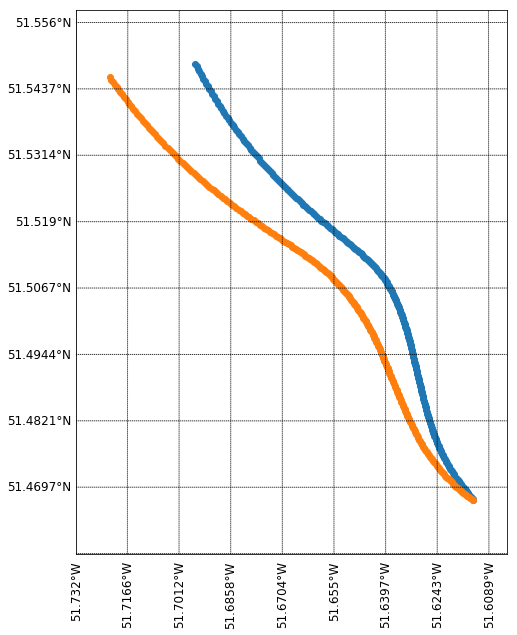

In [94]:
fig, ax = sim.plot_track(['analytical', 'newtonian'])

# XXX

# Testing Drift Model with Constant Metocean Fields

In [95]:
def plot_test_case(sim, label='', title='', arrow_scale=1e5, pads=[0.01]*4, gap=20, s=1, loc=0):
    
    forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])
    arrow_colors = ['red', 'blue', 'green', 'black']
    arrow_labels = ['Air', 'Water', 'Coriolis', 'Pressure']
    vectors = [[forces['Fax'], forces['Fay']], [forces['Fwx'], forces['Fwy']],
              [forces['Fcx'], forces['Fcy']], [forces['Fwpx'], forces['Fwpy']]]
    map_kwargs = {'pads': pads}
    scatter_kwargs = {'s': s}
    quiver_kwargs = {'color': arrow_colors, 'label': arrow_labels, 'scale': arrow_scale, 'gap': gap}
    legend_kwargs = {'loc': loc}
    kwargs = {'vectors': vectors, 'title': title,
              'map_kwargs': map_kwargs,
              'quiver_kwargs': quiver_kwargs,
              'scatter_kwargs': scatter_kwargs,
              'legend_kwargs': legend_kwargs}
    
    return sim.plot_track([label], **kwargs)

In [96]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

## Default

In [97]:
label = 'default'
xds = sim.run_simulation(store_results_as=label)

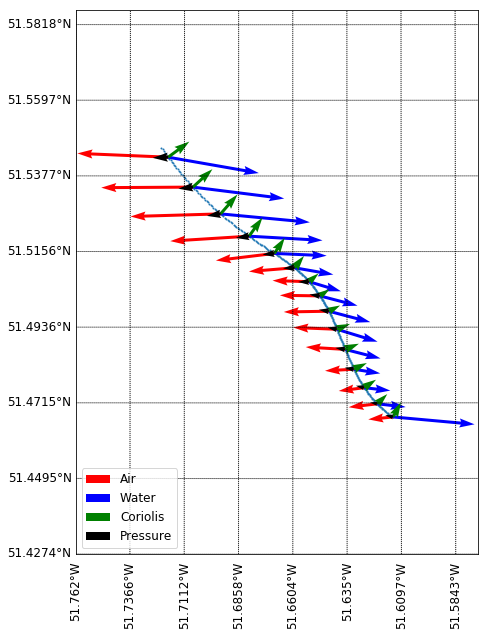

In [98]:
fig, ax = plot_test_case(sim, 'default', arrow_scale=2e6, pads=[0.04]*4)
fig.savefig(plot_dir + label + '.png')

## No Current, Constant Wind

In [99]:
label = 'no_current_constant_wind'
title = 'No Current Constant Wind'
sim.start_velocity = 0, 0
sim.set_constant_current((0, 0))
sim.set_constant_wind((10, 0))
xds = sim.run_simulation(store_results_as=label)

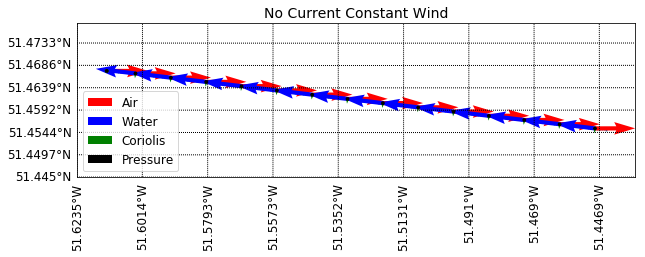

In [100]:
fig, ax = plot_test_case(sim, label=label, title=title, arrow_scale=1e7)
fig.savefig(plot_dir + label + '.png')

## No Wind, Constant Current

In [101]:
label = 'no_wind_constant_current'
title = 'No Wind Constant Current'
sim.start_velocity = 0.1, 0
sim.set_constant_current((0.1, 0))
sim.set_constant_wind((0, 0))
xds = sim.run_simulation(store_results_as=label)

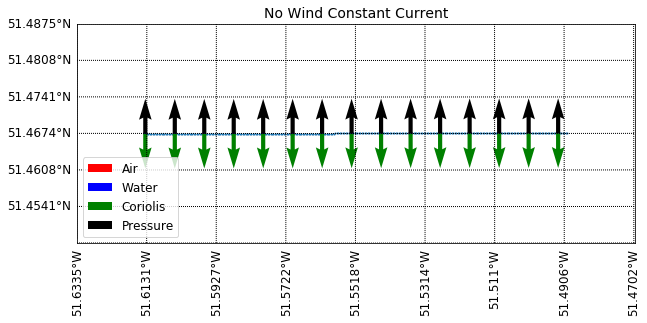

In [102]:
fig, ax = plot_test_case(sim, label=label, title=title, arrow_scale=1e6, pads=[0.02]*4)
fig.savefig(plot_dir + label + '.png')

## No Wind or Current

In [103]:
label = 'no_wind_or_current'
title = 'No Current or Wind'
sim.start_velocity = 0.01, 0
sim.set_constant_current((0, 0))
sim.set_constant_wind((0, 0))
xds = sim.run_simulation(store_results_as=label)

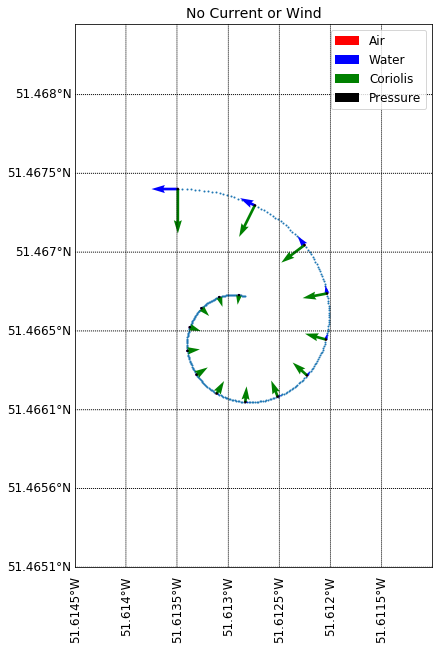

In [104]:
fig, ax = plot_test_case(sim, label=label, title=title, arrow_scale=5e4, pads=[0.001]*4)
fig.savefig(plot_dir + label + '.png')

## Constant Current and Wind

In [105]:
label = 'constant_current_and_wind'
title = 'Constant Current and Wind'
sim.start_velocity = 0, 0
sim.set_constant_current((0.1, 0))
sim.set_constant_wind((10, 0))
xds = sim.run_simulation(store_results_as=label)

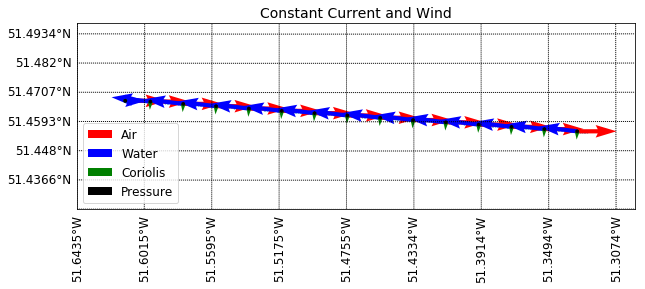

In [106]:
fig, ax = plot_test_case(sim, label=label, title=title, arrow_scale=1e7, pads=[0.03]*4)
fig.savefig(plot_dir + label + '.png')

# Simulation

In [107]:
start_time = np.datetime64('2015-04-24T22:53:29')
end_time = np.timedelta64(1, 'D')
tc = test_case.TestCase(start_time=start_time, end_time=end_time)

In [108]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results1 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results2 = sim.run_simulation(store_results_as=label, **run_sim_kwargs)

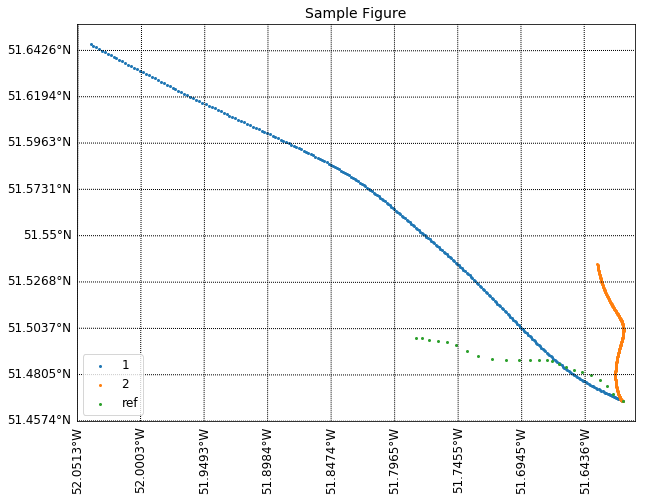

In [109]:
s = 4
scatter_kwargs = {'s': s}
title='Sample Figure'
labels = ['1', '2', 'ref']
kwargs = {'scatter_kwargs': scatter_kwargs, 'title': title, 'labels': labels}

fig, ax = plot.plot_track([results1['latitude'].values, results1['longitude'].values],
                          [results2['latitude'].values, results2['longitude'].values],
                          [tc.ref_lats.values, tc.ref_lons.values], **kwargs)                

# Optimization

In [110]:
if run_optimization:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[0.01, 15], [0.01, 15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

    optimization_result

## Simulation with Optimization Result

In [111]:
if run_optimization:

    Ca, Cw = optimization_result.x

    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
    results = sim.run_simulation(**run_sim_kwargs)

    s = 4
    scatter_kwargs = {'s': s}
    title='Sample Figure'
    labels = ['1', '2', 'ref']
    kwargs = {'scatter_kwargs': scatter_kwargs, 'title': title, 'labels': labels}

    fig, ax = plot.plot_track([results['latitude'].values, results['longitude'].values],
                          [tc.ref_lats.values, tc.ref_lons.values], **kwargs)
    

# Surface Optimization

In [112]:
if run_optimization:
    
    Ca_num = 6
    Cw_num = 6
    Ca_lower_bound = 8; Ca_upper_bound = 12
    Cw_lower_bound = 0.1; Cw_upper_bound = 8

    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [113]:
if run_optimization:
    
    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

In [114]:
if run_optimization:

    fig = plt.figure(figsize=(14,7))

    plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

    plt.xticks(Ca_vec)#, rotation='vertical')
    plt.yticks(Cw_vec)

    plt.xlabel('Ca')
    plt.ylabel('Cw')

    plt.colorbar()

    plt.show()

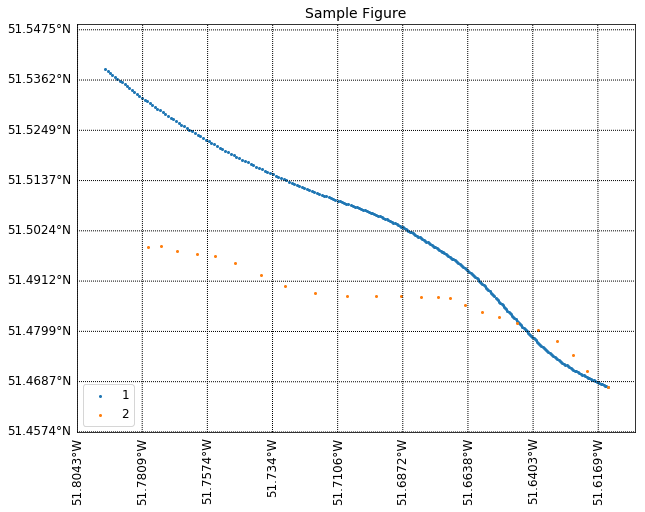

In [115]:
Ca, Cw = (11.2 + 12) / 2, (3.26 + 4.84) / 2

run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(**run_sim_kwargs)

s = 4
scatter_kwargs = {'s': s}
title='Sample Figure'
labels = ['1', '2', 'ref']
kwargs = {'scatter_kwargs': scatter_kwargs, 'title': title, 'labels': labels}

fig, ax = plot.plot_track([results['latitude'].values, results['longitude'].values],
                      [tc.ref_lats.values, tc.ref_lons.values], **kwargs)

# Ekman

In [116]:
label = 'ekman'

# No Ekman
ekman = False
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='no_ekman', **kwargs)

# Ekman to depth of 100 m
ekman = True
kwargs = {'ekman': ekman}
xds = sim.run_simulation(store_results_as='ekman_100', **kwargs)

# Ekman to depth of 1000 m
ekman = True
depth_vec = np.arange(0, -1100, -100)
kwargs = {'ekman': ekman, 'depth_vec': depth_vec}
xds = sim.run_simulation(store_results_as='ekman_1000', **kwargs)

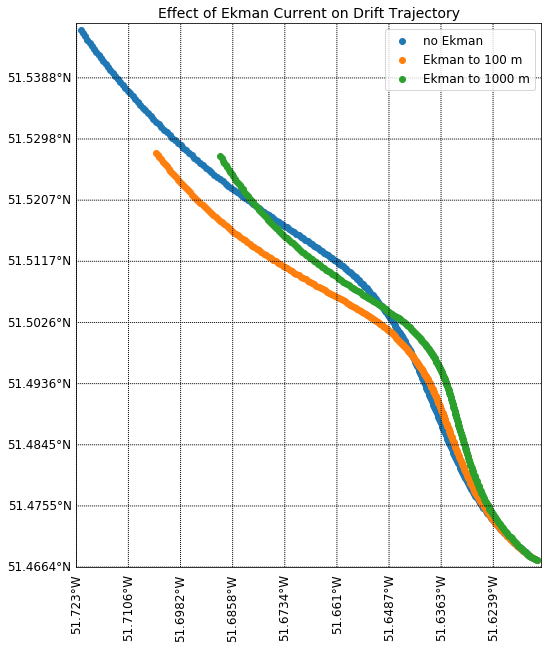

In [117]:
title = 'Effect of Ekman Current on Drift Trajectory'
pads = [0.001] * 4
labels = ['no Ekman', 'Ekman to 100 m', 'Ekman to 1000 m']
legend_kwargs = {'loc': 1}
map_kwargs = {'pads': pads}
kwargs = {'map_kwargs': map_kwargs, 'labels': labels, 'title': title, 'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(['no_ekman', 'ekman_100', 'ekman_1000'], **kwargs)
fig.savefig(plot_dir + label + '.png')

# Varying Berg Size

In [118]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [119]:
sizes = ['SM', 'MED', 'LG', 'VLG']
labels = ['SM', 'MED', 'LG', 'VLG']

for size, label in zip(sizes, labels):

    sim.iceberg_size = size
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)
    

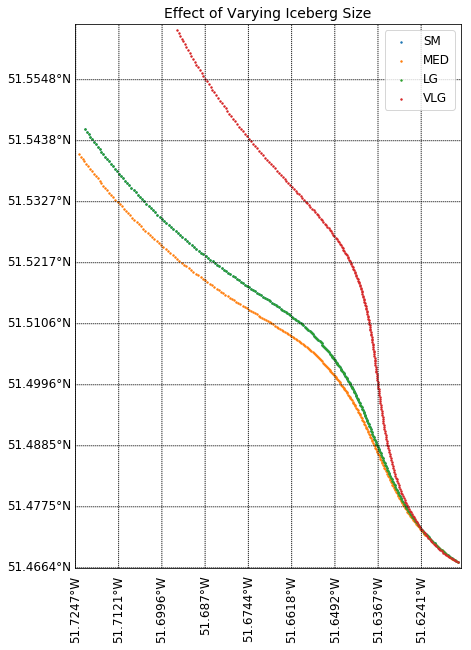

In [120]:
title = 'Effect of Varying Iceberg Size'
pads = [0.001] * 4 
map_kwargs = {'pads': pads}
s = 2
scatter_kwargs = {'s': s}
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'labels': labels,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs,
          'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'sizes' + '.png')

In [121]:
size_class = 'LG'
min_length, max_length = iceberg.WATERLINE_LENGTH_RANGE_BY_SIZE[size_class]
min_height, max_height = iceberg.SAIL_HEIGHT_RANGE_BY_SIZE[size_class]

In [122]:
num_intervals = 10
lengths = np.linspace(min_length, max_length, num_intervals)
heights = np.linspace(min_height, max_height, num_intervals)
labels = []

for length, height in zip(lengths, heights):
    
    label = '{},{}'.format(int(length), int(height))
    labels.append(label)
    sim.iceberg_size = length, height
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)    

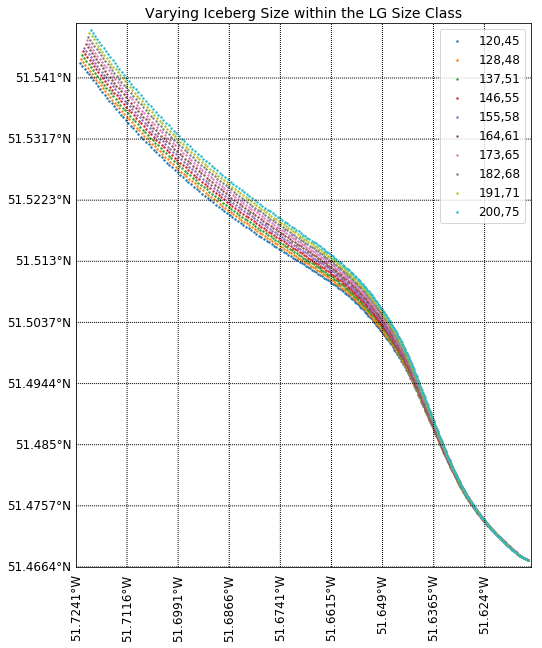

In [123]:
title = f'Varying Iceberg Size within the {size_class} Size Class'
pads = [0.001] * 4 
map_kwargs = {'pads': pads}
s = 2
scatter_kwargs = {'s': s}
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'labels': labels,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs,
          'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + f'{size_class}_size_range.png')

# Varying Berg Shape

In [124]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [125]:
shapes = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']
labels = ['TAB', 'NTAB', 'DOM', 'PIN', 'WDG', 'DD', 'BLK']

for shape, label in zip(shapes, labels):

    sim.iceberg_shape = shape
    sim.reload_iceberg
    xds = sim.run_simulation(store_results_as=label)


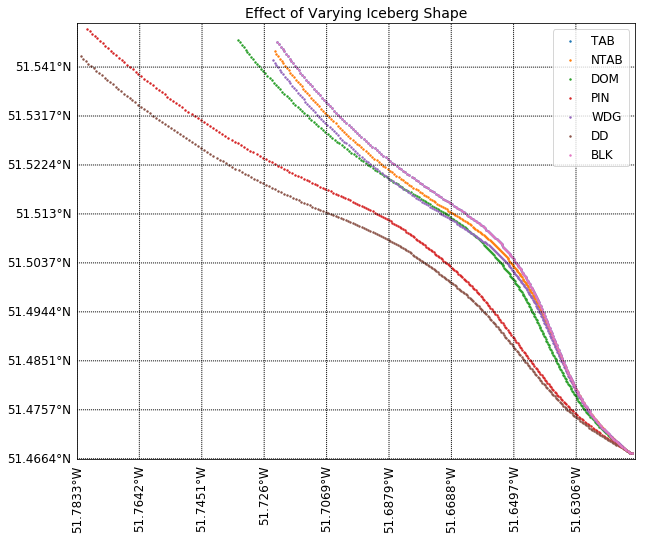

In [126]:
title = 'Effect of Varying Iceberg Shape'
pads = [0.001] * 4 
map_kwargs = {'pads': pads}
s = 2
scatter_kwargs = {'s': s}
kwargs = {'title': title, 'labels': labels,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs,
          'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'shapes' + '.png')

# Effect of changing timestepper

In [127]:
sim = simulator.Simulator(tc.time_frame, tc.start_location, tc.start_velocity)

In [128]:
label = 'euler'
xds = sim.run_simulation(store_results_as=label)

In [129]:
label = 'rk2'
sim.time_stepper = timesteppers.rk2
xds = sim.run_simulation(store_results_as=label)

In [130]:
label = 'rk4'
sim.time_stepper = timesteppers.rk4
xds = sim.run_simulation(store_results_as=label)

In [131]:
label = 'ab2'
sim.time_stepper = timesteppers.ab2
xds = sim.run_simulation(store_results_as=label)

In [132]:
label = 'ab3'
sim.time_stepper = timesteppers.ab3
xds = sim.run_simulation(store_results_as=label)

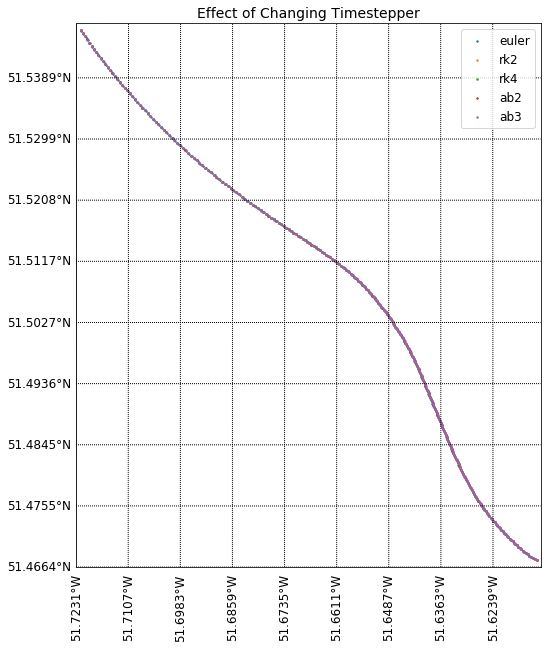

In [133]:
title = 'Effect of Changing Timestepper'
labels = ['euler', 'rk2', 'rk4', 'ab2', 'ab3']
pads = [0.001] * 4 
map_kwargs = {'pads': pads}
s = 2
scatter_kwargs = {'s': s}
kwargs = {'title': title, 'labels': labels,
          'map_kwargs': map_kwargs,
          'scatter_kwargs': scatter_kwargs,
          'legend_kwargs': legend_kwargs}
fig, ax = sim.plot_track(labels, **kwargs)
fig.savefig(plot_dir + 'timesteppers' + '.png')